In [ ]:
# Notes to self:

# The clustering on skills didn't work because there isn't enough skills per user.
# Almost all users have about 5 skills, but there isn't enough overlap between them.
# Futhermore, there is just about no signal relating the features to hourly rate.
# Need to pivot and think of some alternative way to use this data.
# Also, I need to figure out why everyone has a "1" for their invoices paid.

### Importing and Merging to get EDA Dataset

In [194]:
# Packages for PostgreSQL Import and Export
from sqlalchemy_utils import database_exists, create_database
from sqlalchemy import create_engine
import psycopg2

# Packages for EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from nltk.corpus import stopwords

# Packages for K-Modes Cluster
import numpy as np
from kmodes.kmodes import KModes

In [195]:
# Ideally I'll move this into the project config.py file
# Otherwise for now I have to just manually assign . . .

dbname = "freelance_db"
username = "Metaverse"
pswd = "Arcifice91"

# Connect to Data
con = None
con = psycopg2.connect(database=dbname, user=username,
                       host='localhost', password=pswd)

# Checking shapes of tables
sql_query = """SELECT * from user_details_table;"""
dtls_table = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * from freelance_table;"""
fl_table = pd.read_sql_query(sql_query, con)

In [196]:
# Merging
# Modifying profile_url in the details table so I can merge it with the fl_table
dtls_table['profile_url'] = "https://www.guru.com"+dtls_table['profile_url']

# Now I'm merging them together to make dt
dt = pd.merge(fl_table, dtls_table, on='profile_url')
dt.shape
dt = dt.drop(columns=(['index_x']))
dt = dt.drop_duplicates(subset='profile_url')

In [197]:
# Merging in data to crosswalk states with region labels
state_region_crswlk = pd.read_csv(
    '~/Desktop/Insight/projects/myrate/data/raw/census-regions/us census bureau regions and divisions.csv')
state_region_crswlk.head()

dt = pd.merge(dt, state_region_crswlk,
              how='left', left_on='state', right_on='State')

# Fixing region value for individuals living in Puerto Rico
dt.loc[dt['state'] == "Puerto Rico", 'Region'] = "Other"

# Exploratory Data Analysis - Outcome: Hourly Rate
### Beginning with investigating the geographic labels 

In [198]:
# What is the overall mean?
print("Mean hourly rate ($):", round(dt['hourly_rate'].mean(), 2))

Mean hourly rate ($): 31.94


In [199]:
# What is the mean by region?
dt.groupby(['Region']).hourly_rate.mean()

# There is some variation, but it is minimal

Region
Midwest      29.724138
Northeast    30.782609
Other        20.000000
South        31.972222
West         34.197719
Name: hourly_rate, dtype: float64

In [200]:
# What is the mean across states?
dt.groupby(['state']).hourly_rate.mean().sort_values().describe()

# Pretty decent spread. This may be the most powerful signal yet.
# If you print out hte full table it is clear that there is variation

count     50.000000
mean      33.764035
std       15.197060
min        8.000000
25%       26.650000
50%       32.175057
75%       36.732353
max      104.000000
Name: hourly_rate, dtype: float64

In [201]:
# What is the variation within states?
state_lvl_hourly_rate_descriptives = {}
state_lvl_hourly_rate_descriptives['min'] = dt.groupby(
    ['state']).hourly_rate.min()
state_lvl_hourly_rate_descriptives['mean'] = dt.groupby(
    ['state']).hourly_rate.mean()
state_lvl_hourly_rate_descriptives['max'] = dt.groupby(
    ['state']).hourly_rate.max()
state_lvl_hourly_rate_descriptives['var'] = dt.groupby(
    ['state']).hourly_rate.var()
dt_state_hr = pd.DataFrame(state_lvl_hourly_rate_descriptives)

# A decent amount of variation within the states

In [202]:
# I tried to break it down further to the city level
# But the city data is really messy and not worth the time sink
# To try and get it set up. The idea would be to merge on
# rural vs urban and see if it can help me filter out a signal.

### Investigating the relationship between a users "rating" and the outcome

In [203]:
# Cleaing it up real quick
dt.rating = dt.rating.str.replace('%', '')
dt.rating = dt.rating.str.replace('NA', '')
dt.rating = pd.to_numeric(dt.rating)

In [204]:
# Starting with Missing Values
print("Number of missing values: ", dt.rating.isna().sum())

Number of missing values:  68


In [205]:
# What does the spread look like for the rest?
dt.rating.describe()

# Basically no variation. Okay, let's make a binary variable (has_rating)

count    911.000000
mean      98.424040
std       11.376479
min        1.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: rating, dtype: float64

In [206]:
# Creating "has_rating"
dt['has_rating'] = None
dt.loc[dt['rating'].isna(), 'has_rating'] = 0
dt.loc[dt['rating'] > 0, 'has_rating'] = 1

# Comparing outcome means by has_rating
dt.groupby(['has_rating']).hourly_rate.mean()

# Small difference, nothing substantial

has_rating
0    34.529412
1    31.743139
Name: hourly_rate, dtype: float64

### Exploring the duration of membership and hourly rate

1. Convert member start date to a date object
2. Calculate years / months they've been a member (to today)

In [207]:
def date_convert(member_since):
    try:
        tmp = datetime.strptime(member_since, '%b, %Y')
        #tmp = tmp.strftime('%Y-%m')
    except:
        tmp = 'NaN'
    return tmp

In [208]:
def years_active(date):
    cur_year = datetime.now().year
    try:
        yrs_active = cur_year - date.year
    except:
        yrs_active = 'NaN'

    return yrs_active

In [209]:
def months_active(date):
    cur_year = datetime.now().year
    cur_month = datetime.now().month

    try:
        mnths_active = (cur_year - date.year)*12 + (cur_month - date.month)
    except:
        mnths_active = 'NaN'

    return mnths_active

In [210]:
# Converting member_since to date
dt.member_since = dt.member_since.str.strip()
dt['start_date'] = dt.member_since.apply(date_convert)
dt['years_active'] = dt.start_date.apply(years_active)
dt['months_active'] = dt.start_date.apply(months_active)

# Therea are 31 NAs. Just going to ignore them for now.

In [211]:
# What I want to understand is:
# How does the hourly rate (average) change across years active?
dt.groupby('years_active').hourly_rate.mean()

# Nothing much. It ramps up if years active > 17. Building that binary.

years_active
0.0     30.869565
1.0     32.279570
2.0     31.409091
3.0     31.804598
4.0     30.594203
5.0     30.295775
6.0     29.396552
7.0     23.527778
8.0     31.758621
9.0     24.173913
10.0    28.482759
11.0    28.192308
12.0    34.178571
13.0    32.521739
14.0    37.481481
15.0    38.652174
16.0    32.541667
17.0    51.190476
18.0    39.384615
19.0    42.533333
20.0    55.000000
Name: hourly_rate, dtype: float64

In [212]:
dt['active_17up'] = (dt['years_active'] >= 17) * 1

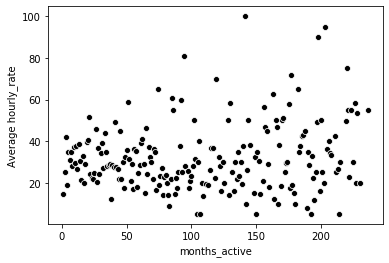

In [213]:
# Okay let's try looking at months active. Maybe on a finer scale there is some difference?
x = dt.groupby('months_active').hourly_rate.mean().index
y = dt.groupby('months_active').hourly_rate.mean()
ax = sns.scatterplot(x=x, y=y,
                     color='black')
ax.set(xlabel='months_active', ylabel='Average hourly_rate')
plt.show()

# No real pattern emerges. Unfortunately not useful.

In [214]:
dt.columns

Index(['profile_url', 'city', 'state', 'country', 'rating', 'earnings',
       'hourly_rate', 'skills_list', 'user_description', 'index_y',
       'member_since', 'earnings_pst_yr', 'earnings_ever', 'employers',
       'invoices_paid', 'largest_employ', 'bio', 'State', 'State Code',
       'Region', 'Division', 'has_rating', 'start_date', 'years_active',
       'months_active', 'active_17up'],
      dtype='object')

### Exploring hourly rate and how it relates to the skills

1. Obtain the dataset that is long by skills and shrink it down to just the skills. I'll work with that for this.
2. Create some quick features such as: # of skills and top skill. These are user level so I can attach them back to dt to have everything in one place.

Note: the skills are standardized on guru which makes this more straightforward

In [215]:
sql_query = """SELECT profile_url, skills_list from freelance_table;"""
skills_table = pd.read_sql_query(sql_query, con)
skills_table_dummies = pd.get_dummies(skills_table, columns=[
                                      'skills_list'], prefix='').groupby(['profile_url']).sum()

In [216]:
# Number of skills
num_skills = skills_table.groupby('profile_url').count()
num_skills = num_skills.rename(columns={"skills_list": "num_skills"})
num_skills = num_skills.reset_index()

In [ ]:
# Merging num skills into dt
dt = pd.merge(dt, num_skills, on="profile_url")

In [219]:
dt.groupby('num_skills').hourly_rate.mean()

num_skills
1    25.620690
2    42.600000
3    27.750000
4    24.381818
5    32.415854
Name: hourly_rate, dtype: float64

In [ ]:
# Seems that for those with less than five skills listed
# they tend to have a lower hourly rate.
dt['less_five_skills'] = (dt['num_skills'] < 5) * 1

In [225]:
# Moving on to something else. Let's look at the top skills (first skill listed)
first_skill = skills_table[skills_table.groupby(
    'profile_url')['skills_list'].cumcount() == 0]

first_skill = first_skill.rename(
    columns={"profile_url": "profile_url", "skills_list": "first_skill"})

dt = pd.merge(dt, first_skill, on="profile_url")

In [235]:
# Exploring First Skills
print("Number of unique skills: ", dt.first_skill.nunique())
dt.groupby('first_skill').first_skill.count().describe()

# There is some repition but not much. Maybe I can get something off the extreme cases.

Number of unique skills:  350


count    350.000000
mean       2.797143
std        4.245543
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       32.000000
Name: first_skill, dtype: float64

In [253]:
# Exploring extreme first skill frequencies
skill_freq = {}
skill_freq['skill_frequency'] = dt.groupby(
    'first_skill').first_skill.count().sort_values(ascending=False)
skill_freq['skills_list'] = dt.groupby(
    'first_skill').first_skill.count().sort_values(ascending=False).index
skill_freq = pd.DataFrame(skill_freq)
skill_freq = skill_freq.reset_index()
skill_freq = skill_freq.drop(['first_skill'], axis=1)

dt = pd.merge(dt, skill_freq, on="skills_list")

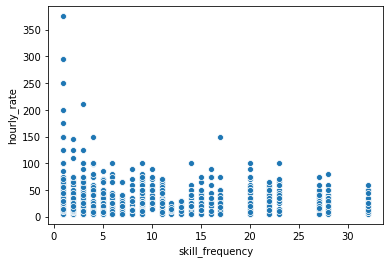

In [257]:
sns.scatterplot(x='skill_frequency', y='hourly_rate', data=dt)

# Nope, not much of anything here.

In [258]:
# Just have to try to keep thinking of ways I could use this information.
# Ideally, I would be able to go group them by category and calculate hourly rate on that
# There may also be an interaction effect occuring between the category and something like
# years of experience.

### Starting the process of using the "bio" data

1. The easiest variable to create is the len(bio)
2. I'll have to try and expand it more using some other techniques

In [259]:
def clean_bio(bio):
    try:
        cleaned_bio = ''.join(s for s in bio if ord(s) > 31 and ord(s) < 126)
    except:
        cleaned_bio = "NaN"
    return cleaned_bio

In [260]:
def len_bio(bio):
    if bio == "NaN":
        return 0
    else:
        return len(bio)

In [268]:
# Average word length in bio
def avg_word_ln(bio):
    try:
        words = bio.split()
        res = (sum(len(word) for word in words)/len(words))
    except:
        res = 0
    return res

In [269]:
# Number of stop words
def num_stopwords(bio):
    stop = stopwords.words('english')

    try:
        res = len([x for x in bio.split() if x in stop])
    except:
        res = -1

    return res

In [264]:
dt['bio_clean'] = dt.bio.apply(clean_bio)

In [265]:
dt['bio_length'] = dt.bio_clean.apply(len_bio)

In [266]:
# Number of separate words in bio
dt['bio_word_count'] = dt['bio_clean'].apply(
    lambda x: len(str(x).split(" ")))

In [270]:
dt['avg_word_length'] = dt['bio_clean'].apply(avg_word_ln)

In [271]:
dt['num_stop'] = dt['bio_clean'].apply(num_stopwords)

In [272]:
# Preprocessing before pulling more features

# Remvoing stop words
stop = stopwords.words('english')
dt['bio_processed'] = dt['bio_clean'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

# Removing punctuation
dt['bio_processed'] = dt['bio_processed'].str.replace(
    '[^\w\s]', '')

# Lower Case
dt['bio_processed'] = dt['bio_processed'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

In [ ]:
# Exploring how these bio features related to hourly rate

# Starting with the length of a users bio
sns.scatterplot(x='bio_length', y='hourly_rate', data=dt)

# Nothing.

In [ ]:
# How about how the word count related to hourly rate?
sns.scatterplot(x='bio_word_count', y='hourly_rate', data=dt)

# Nope, again nothing of interest here.

In [ ]:
# Okay, what about how word length
sns.scatterplot(x='hourly_rate', y='avg_word_length', data=dt)

# Hmm, no. But there are some very unusual outliers.

In [ ]:
# Lastly, the number of stop words
sns.scatterplot(x='num_stop', y='hourly_rate', data=dt)

In [ ]:
# Whole lot of nothing came out of the bio features.

### Comparing number of employers and hourly rate

Nevermind. There is no variance.

### Some final cleaning

In [287]:
# Making State dummy variables
state_dummies = pd.get_dummies(dt['state'])
dt = pd.concat([dt, state_dummies], axis=1)

In [288]:
# Earnings per Month
dt['earnings_ever'] = dt['earnings_ever'].str.replace('$', '')
dt['earnings_ever'] = dt['earnings_ever'].str.replace(',', '')
dt['earnings_ever'] = pd.to_numeric(dt['earnings_ever'])
dt['earnings_pr_month'] = dt['earnings_ever'] / \
    dt['months_active']

### Saving out Modified Dataset

1. First printing the columns I have for reference.
2. Saving it to a new table in the postgreSQL database

In [289]:

dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   profile_url           979 non-null    object        
 1   city                  979 non-null    object        
 2   state                 979 non-null    object        
 3   country               979 non-null    object        
 4   rating                911 non-null    float64       
 5   earnings              979 non-null    object        
 6   hourly_rate           979 non-null    int64         
 7   skills_list           979 non-null    object        
 8   user_description      979 non-null    object        
 9   index_y               979 non-null    int64         
 10  member_since          979 non-null    object        
 11  earnings_pst_yr       948 non-null    object        
 12  earnings_ever         948 non-null    float64       
 13  employers           

In [314]:
col_locs = [6,21,23,25,27,29]
x = list(range(36,86))
col_locs.extend(x)
print(col_locs)

[6, 21, 23, 25, 27, 29, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]


In [315]:
# Cleaning to just variables that will be used in the model
analysis_dt = dt.iloc[:,col_locs]
analysis_dt = analysis_dt.dropna()  # Removing people with NA
analysis_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948 entries, 0 to 978
Data columns (total 56 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hourly_rate           948 non-null    int64  
 1   has_rating            948 non-null    object 
 2   years_active          948 non-null    float64
 3   active_17up           948 non-null    int64  
 4   less_five_skills      948 non-null    int64  
 5   skill_frequency       948 non-null    int64  
 6   Alabama               948 non-null    uint8  
 7   Arizona               948 non-null    uint8  
 8   Arkansas              948 non-null    uint8  
 9   California            948 non-null    uint8  
 10  Colorado              948 non-null    uint8  
 11  Connecticut           948 non-null    uint8  
 12  Delaware              948 non-null    uint8  
 13  District of Columbia  948 non-null    uint8  
 14  Florida               948 non-null    uint8  
 15  Georgia               9

In [316]:
# Connect to the database and save data to it
engine = create_engine('postgresql://%s:%s@localhost/%s' %
                       (username, pswd, dbname))

In [317]:
analysis_dt.to_sql("analysis_table", engine, if_exists='replace')

### Working on clustering the skills

1. This didn't work. I think the reason is because I don't have enough skills for each user. Therefore, it can't find enough similarity between them. Maybe I could go back and jump into each users url and scrape their entire skills list? Time consuming.

In [ ]:
# Found K-Modes on stackoverflow
# Following the package documentation
# Ref: https://pypi.org/project/kmodes/
# Ref: https://stackoverflow.com/questions/42639824/python-k-modes-explanation
# Ref: https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering

In [ ]:
# Cleaning column names from the dummies database
skills_table_dummies.columns = skills_table_dummies.columns.str.strip().str.lower().str.replace(
    ' ', '_').str.replace('(', '').str.replace(')', '').str.replace('_', '')

In [ ]:
skills_table_dummies.head()

In [ ]:
# Modeling with K Modes
cost = []
for num_clusters in list(range(20, 30)):
    kmode = KModes(n_clusters=num_clusters, init="Huang", verbose=0)
    kmode.fit_predict(skills_table_dummies)
    cost.append(kmode.cost_)
    print("Finished Cluster: " + str(num_clusters))

In [ ]:
y = np.array([i for i in range(20, 30, 1)])
plt.plot(y, cost)

In [ ]:
kmode = KModes(n_clusters=28, init='Huang', verbose=0)
clusters = kmode.fit_predict(skills_table_dummies)

kmodes = kmode.cluster_centroids_
shape = kmodes.shape

for i in range(shape[0]):
    if sum(kmodes[i, :]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i, :]
        for j in skills_table_dummies.columns[np.nonzero(cent)]:
            print(j)

In [ ]:
clust_assigned = km.predict(skills_table_dummies)

In [ ]:
unique, counts = np.unique(clust_assigned, return_counts=True)
dict(zip(unique, counts))

In [ ]:
user_cluster_crosswalk = pd.DataFrame(
    skills_table['profile_url'].unique(), columns=["profile_url"]).sort_values(by="profile_url")
user_cluster_crosswalk['cluster'] = clust_assigned
user_cluster_crosswalk[user_cluster_crosswalk['cluster'] == 0].head()

In [ ]:
# Merging into the skills table to investigate those with "no skills"
tmp = pd.merge(skills_table, user_cluster_crosswalk, on="profile_url")
tmp[tmp['cluster'] == 0]

In [ ]:
# It seems to not be working great.
# Why is it putting so many people into the no skills cluster?

# EDA for the Probability of Getting a Job (0/1)

### Outcome: Probability of getting a job  . . . ever?

1. Need to clean all of this up

In [ ]:
# What about the (obvious) relationship between memebershp time and # of jobs completed
# How strong is the relationship?
# First have to clean the invoices paid variable
dt.invoices_paid = dt.invoices_paid.str.replace(',', '')
dt.invoices_paid = pd.to_numeric(dt.invoices_paid)
dt.invoices_paid.describe()

In [ ]:
# Who is NA? I have a whole bunch of 1s but then some NAs?
# The question for a poisson model is: did they just have no invoices OR
# were they never going to have any invoices.
# Looked at some of them and I'll treat them as zeros. So there are really that many ones?!?
dt[dt.invoices_paid.isna()].head()

In [ ]:
# Assigning zero to the NAs. This is important!!
dt.loc[dt.invoices_paid.isna(), 'invoices_paid'] = 0

In [ ]:
sns.distplot(dt.invoices_paid)

In [ ]:
# Wow, very heavy on the zeros. Let's look closer.
dt.invoices_paid.describe()

In [ ]:
# Ah, so it is truncating at one.
# This is going to be problematic for those who are actually at a value of one.
# I can either rerun the scrape and create something to make the val = 0
# or I can just move forward. . .

# For now I'm going to keep moving forward and treat 1 as 0.
# Note, it is more likely than not that they are = 0

In [ ]:
# Checking dist vs months active (no 1s)
sns.scatterplot(x='months_active', y='invoices_paid',
                data=dt[dt.invoices_paid > 1])

In [ ]:
# A few massive outliers. Going to rough chop it down and replot
invoice_gtr_one = dt.invoices_paid > 1
invoice_ls_2000 = dt.invoices_paid < 2000
sns.scatterplot(x='months_active', y='invoices_paid',
                data=dt[invoice_gtr_one & invoice_ls_2000])

In [ ]:
# hmm, there may be a slight signal but you would expect a stronger trend

In [ ]:
# Checking dist vs years active (no 1s)
sns.scatterplot(x='years_active', y='invoices_paid',
                data=dt[invoice_gtr_one & invoice_ls_2000])
# Slight postive non-linear trend bu there is a HUGE outlier

### Invoices Paid - Notes

It has a weak-ish relationship with time. There are a lot of really heavy users of the platform that dominate the market. Let's zoom into the first year and see what it looks like.

In [ ]:
# Looking at invoices pad in the first few months (among those only active for a shorter period of time)
sns.scatterplot(x='months_active',
                y='invoices_paid',
                data=dt[dt['years_active'] < 2])

In [ ]:
# Calculating invoices / time active
dt['invoices_per_month'] = dt['invoices_paid'] / \
    dt['months_active']
sns.distplot(dt.invoices_per_month)
print(dt.invoices_per_month.describe())

In [ ]:
# Loaded on zero with a long tail. Continues to sell that there are some serious power users.
# Average invoice per month is equal to one, but I left in the 1s that could be zeros. . .
# Real average is likely near zero.

# The question now is: Does this mean differ by any characteristic that I observe in the data?
# For people with a different skill set (Andriod) do they have a higher mean invoice/month rate?
# For people in different regions do they have a higher mean invoice/month rate?
# For people with lower hourly rates do they have a higher mean invoice/month rate??

# The next important step is to figure out how to use the skills data.
# It would be great to try and create clusters of the skills.